In [27]:
import os
import os.path
import glob
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [17]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [5]:
# Creating base_model (VGG16 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)

In [19]:
filename = 'virussign-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vgg16features = np.load(filename)
else:
    print("Extracting features from VGG16 layers ...")
    vgg16features = base_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vgg16features)

Loading VGG16 extracted features from virussign-vgg16features.npy ...


In [20]:
vgg16features.shape

(9339, 7, 7, 512)

In [21]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [22]:
# Training top_model and saving min training loss weights
num_epochs=500
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='top_model-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-500epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vgg16features[train_indices]
    Y_train = Y[train_indices]
    X_test = vgg16features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/500
8394/8394 [==============================] - 2s - loss: 13.7168 - acc: 0.0295 - val_loss: 9.7087 - val_acc: 0.3481
Epoch 2/500
8394/8394 [==============================] - 1s - loss: 10.3689 - acc: 0.3026 - val_loss: 7.8450 - val_acc: 0.4995
Epoch 3/500
8394/8394 [==============================] - 1s - loss: 8.9626 - acc: 0.4159 - val_loss: 7.4208 - val_acc: 0.5228
Epoch 4/500
8394/8394 [==============================] - 1s - loss: 8.0044 - acc: 0.4786 - val_loss: 6.9679 - val_acc: 0.5534
Epoch 5/500
8394/8394 [==============================] - 1s - loss: 7.5326 - acc: 0.5095 - val_loss: 6.6841 - val_acc: 0.5841
Epoch 6/500
8394/8394 [==============================] - 1s - loss: 7.1593 - acc: 0.5366 - val_loss: 6.3750 - val_acc: 0.5915
Epoch 7/500
8394/8394 [==============================] - 1s - loss: 6.8926 - acc: 0.5518 - val_loss: 5.8084 - val_acc: 0.6307
Epoch 8/500
8394/8394 [==============================] - 1s - loss: 6

8394/8394 [==============================] - 1s - loss: 0.4830 - acc: 0.9599 - val_loss: 0.5159 - val_acc: 0.9556
Epoch 130/500
8394/8394 [==============================] - 1s - loss: 0.4831 - acc: 0.9575 - val_loss: 0.5148 - val_acc: 0.9556
Epoch 131/500
8394/8394 [==============================] - 1s - loss: 0.4928 - acc: 0.9574 - val_loss: 0.5061 - val_acc: 0.9556
Epoch 132/500
8394/8394 [==============================] - 1s - loss: 0.4897 - acc: 0.9575 - val_loss: 0.5001 - val_acc: 0.9566
Epoch 133/500
8394/8394 [==============================] - 1s - loss: 0.4850 - acc: 0.9587 - val_loss: 0.4987 - val_acc: 0.9598
Epoch 134/500
8394/8394 [==============================] - 1s - loss: 0.4880 - acc: 0.9591 - val_loss: 0.4990 - val_acc: 0.9598
Epoch 135/500
8394/8394 [==============================] - 1s - loss: 0.4768 - acc: 0.9607 - val_loss: 0.5013 - val_acc: 0.9587
Epoch 136/500
8394/8394 [==============================] - 1s - loss: 0.4992 - acc: 0.9569 - val_loss: 0.5033 - val_ac

8394/8394 [==============================] - 1s - loss: 0.2273 - acc: 0.9764 - val_loss: 0.2892 - val_acc: 0.9683
Epoch 258/500
8394/8394 [==============================] - 1s - loss: 0.2315 - acc: 0.9761 - val_loss: 0.2884 - val_acc: 0.9693
Epoch 259/500
8394/8394 [==============================] - 1s - loss: 0.2409 - acc: 0.9737 - val_loss: 0.2894 - val_acc: 0.9704
Epoch 260/500
8394/8394 [==============================] - 1s - loss: 0.2250 - acc: 0.9777 - val_loss: 0.2899 - val_acc: 0.9693
Epoch 261/500
8394/8394 [==============================] - 1s - loss: 0.2291 - acc: 0.9780 - val_loss: 0.2906 - val_acc: 0.9693
Epoch 262/500
8394/8394 [==============================] - 1s - loss: 0.2306 - acc: 0.9766 - val_loss: 0.2917 - val_acc: 0.9704
Epoch 263/500
8394/8394 [==============================] - 1s - loss: 0.2302 - acc: 0.9775 - val_loss: 0.2928 - val_acc: 0.9714
Epoch 264/500
8394/8394 [==============================] - 1s - loss: 0.2312 - acc: 0.9763 - val_loss: 0.2964 - val_ac

8394/8394 [==============================] - 1s - loss: 0.2241 - acc: 0.9771 - val_loss: 0.2840 - val_acc: 0.9693
Epoch 386/500
8394/8394 [==============================] - 1s - loss: 0.2241 - acc: 0.9784 - val_loss: 0.2862 - val_acc: 0.9693
Epoch 387/500
8394/8394 [==============================] - 1s - loss: 0.2204 - acc: 0.9781 - val_loss: 0.2873 - val_acc: 0.9683
Epoch 388/500
8394/8394 [==============================] - 1s - loss: 0.2250 - acc: 0.9764 - val_loss: 0.2858 - val_acc: 0.9683
Epoch 389/500
8394/8394 [==============================] - 1s - loss: 0.2192 - acc: 0.9794 - val_loss: 0.2836 - val_acc: 0.9693
Epoch 390/500
8394/8394 [==============================] - 1s - loss: 0.2205 - acc: 0.9792 - val_loss: 0.2825 - val_acc: 0.9693
Epoch 391/500
8394/8394 [==============================] - 1s - loss: 0.2267 - acc: 0.9781 - val_loss: 0.2819 - val_acc: 0.9693
Epoch 392/500
8394/8394 [==============================] - 1s - loss: 0.2262 - acc: 0.9766 - val_loss: 0.2818 - val_ac

8397/8397 [==============================] - 1s - loss: 2.1815 - acc: 0.8349 - val_loss: 1.5596 - val_acc: 0.9023
Epoch 13/500
8397/8397 [==============================] - 1s - loss: 2.0351 - acc: 0.8434 - val_loss: 1.5497 - val_acc: 0.9023
Epoch 14/500
8397/8397 [==============================] - 1s - loss: 1.9235 - acc: 0.8523 - val_loss: 1.4978 - val_acc: 0.9013
Epoch 15/500
8397/8397 [==============================] - 1s - loss: 1.8279 - acc: 0.8610 - val_loss: 1.3864 - val_acc: 0.9013
Epoch 16/500
8397/8397 [==============================] - 1s - loss: 1.7828 - acc: 0.8632 - val_loss: 1.2691 - val_acc: 0.9055
Epoch 17/500
8397/8397 [==============================] - 1s - loss: 1.6732 - acc: 0.8666 - val_loss: 1.1287 - val_acc: 0.9034
Epoch 18/500
8397/8397 [==============================] - 1s - loss: 1.5371 - acc: 0.8701 - val_loss: 0.9695 - val_acc: 0.9055
Epoch 19/500
8397/8397 [==============================] - 1s - loss: 1.3229 - acc: 0.8747 - val_loss: 0.8636 - val_acc: 0.90

8397/8397 [==============================] - 1s - loss: 0.3584 - acc: 0.9433 - val_loss: 0.2862 - val_acc: 0.9575
Epoch 141/500
8397/8397 [==============================] - 1s - loss: 0.3631 - acc: 0.9430 - val_loss: 0.2855 - val_acc: 0.9575
Epoch 142/500
8397/8397 [==============================] - 1s - loss: 0.3609 - acc: 0.9431 - val_loss: 0.2859 - val_acc: 0.9586
Epoch 143/500
8397/8397 [==============================] - 1s - loss: 0.3592 - acc: 0.9430 - val_loss: 0.2867 - val_acc: 0.9586
Epoch 144/500
8397/8397 [==============================] - 1s - loss: 0.3573 - acc: 0.9428 - val_loss: 0.2863 - val_acc: 0.9713
Epoch 145/500
8397/8397 [==============================] - 1s - loss: 0.3581 - acc: 0.9453 - val_loss: 0.2847 - val_acc: 0.9713
Epoch 146/500
8397/8397 [==============================] - 1s - loss: 0.3492 - acc: 0.9468 - val_loss: 0.2835 - val_acc: 0.9713
Epoch 147/500
8397/8397 [==============================] - 1s - loss: 0.3551 - acc: 0.9437 - val_loss: 0.2837 - val_ac

8397/8397 [==============================] - 1s - loss: 0.3018 - acc: 0.9515 - val_loss: 0.2670 - val_acc: 0.9692
Epoch 269/500
8397/8397 [==============================] - 1s - loss: 0.3132 - acc: 0.9495 - val_loss: 0.2668 - val_acc: 0.9692
Epoch 270/500
8397/8397 [==============================] - 1s - loss: 0.3061 - acc: 0.9511 - val_loss: 0.2675 - val_acc: 0.9692
Epoch 271/500
8397/8397 [==============================] - 1s - loss: 0.3088 - acc: 0.9501 - val_loss: 0.2687 - val_acc: 0.9692
Epoch 272/500
8397/8397 [==============================] - 1s - loss: 0.3099 - acc: 0.9505 - val_loss: 0.2687 - val_acc: 0.9692
Epoch 273/500
8397/8397 [==============================] - 1s - loss: 0.3061 - acc: 0.9518 - val_loss: 0.2686 - val_acc: 0.9692
Epoch 274/500
8397/8397 [==============================] - 1s - loss: 0.3023 - acc: 0.9538 - val_loss: 0.2689 - val_acc: 0.9692
Epoch 275/500
8397/8397 [==============================] - 1s - loss: 0.3103 - acc: 0.9502 - val_loss: 0.2690 - val_ac

8397/8397 [==============================] - 1s - loss: 0.2866 - acc: 0.9512 - val_loss: 0.2509 - val_acc: 0.9692
Epoch 397/500
8397/8397 [==============================] - 1s - loss: 0.2785 - acc: 0.9543 - val_loss: 0.2490 - val_acc: 0.9703
Epoch 398/500
8397/8397 [==============================] - 1s - loss: 0.2768 - acc: 0.9538 - val_loss: 0.2479 - val_acc: 0.9703
Epoch 399/500
8397/8397 [==============================] - 1s - loss: 0.2911 - acc: 0.9506 - val_loss: 0.2484 - val_acc: 0.9703
Epoch 400/500
8397/8397 [==============================] - 1s - loss: 0.2764 - acc: 0.9556 - val_loss: 0.2492 - val_acc: 0.9703
Epoch 401/500
8397/8397 [==============================] - 1s - loss: 0.2770 - acc: 0.9553 - val_loss: 0.2500 - val_acc: 0.9692
Epoch 402/500
8397/8397 [==============================] - 1s - loss: 0.2808 - acc: 0.9527 - val_loss: 0.2496 - val_acc: 0.9703
Epoch 403/500
8397/8397 [==============================] - 1s - loss: 0.2836 - acc: 0.9520 - val_loss: 0.2485 - val_ac

8401/8401 [==============================] - 1s - loss: 0.5854 - acc: 0.8851 - val_loss: 0.4034 - val_acc: 0.9446
Epoch 24/500
8401/8401 [==============================] - 1s - loss: 0.5563 - acc: 0.8870 - val_loss: 0.3878 - val_acc: 0.9499
Epoch 25/500
8401/8401 [==============================] - 1s - loss: 0.5466 - acc: 0.8900 - val_loss: 0.3812 - val_acc: 0.9488
Epoch 26/500
8401/8401 [==============================] - 1s - loss: 0.5501 - acc: 0.8929 - val_loss: 0.3793 - val_acc: 0.9499
Epoch 27/500
8401/8401 [==============================] - 1s - loss: 0.4986 - acc: 0.9041 - val_loss: 0.3663 - val_acc: 0.9542
Epoch 28/500
8401/8401 [==============================] - 1s - loss: 0.4827 - acc: 0.9079 - val_loss: 0.3534 - val_acc: 0.9510
Epoch 29/500
8401/8401 [==============================] - 1s - loss: 0.4780 - acc: 0.9105 - val_loss: 0.3473 - val_acc: 0.9488
Epoch 30/500
8401/8401 [==============================] - 1s - loss: 0.4672 - acc: 0.9124 - val_loss: 0.3441 - val_acc: 0.95

8401/8401 [==============================] - 1s - loss: 0.2637 - acc: 0.9724 - val_loss: 0.3013 - val_acc: 0.9755
Epoch 152/500
8401/8401 [==============================] - 1s - loss: 0.2575 - acc: 0.9750 - val_loss: 0.3031 - val_acc: 0.9723
Epoch 153/500
8401/8401 [==============================] - 1s - loss: 0.2625 - acc: 0.9745 - val_loss: 0.3051 - val_acc: 0.9712
Epoch 154/500
8401/8401 [==============================] - 1s - loss: 0.2582 - acc: 0.9748 - val_loss: 0.3065 - val_acc: 0.9723
Epoch 155/500
8401/8401 [==============================] - 1s - loss: 0.2568 - acc: 0.9751 - val_loss: 0.3044 - val_acc: 0.9723
Epoch 156/500
8401/8401 [==============================] - 1s - loss: 0.2618 - acc: 0.9754 - val_loss: 0.3014 - val_acc: 0.9733
Epoch 157/500
8401/8401 [==============================] - 1s - loss: 0.2551 - acc: 0.9745 - val_loss: 0.2984 - val_acc: 0.9755
Epoch 158/500
8401/8401 [==============================] - 1s - loss: 0.2614 - acc: 0.9741 - val_loss: 0.2989 - val_ac

8401/8401 [==============================] - 1s - loss: 0.2404 - acc: 0.9777 - val_loss: 0.3121 - val_acc: 0.9744
Epoch 280/500
8401/8401 [==============================] - 1s - loss: 0.2361 - acc: 0.9792 - val_loss: 0.3073 - val_acc: 0.9744
Epoch 281/500
8401/8401 [==============================] - 1s - loss: 0.2409 - acc: 0.9773 - val_loss: 0.2986 - val_acc: 0.9744
Epoch 282/500
8401/8401 [==============================] - 1s - loss: 0.2367 - acc: 0.9777 - val_loss: 0.2919 - val_acc: 0.9744
Epoch 283/500
8401/8401 [==============================] - 1s - loss: 0.2356 - acc: 0.9787 - val_loss: 0.2876 - val_acc: 0.9765
Epoch 284/500
8401/8401 [==============================] - 1s - loss: 0.2330 - acc: 0.9793 - val_loss: 0.2848 - val_acc: 0.9776
Epoch 285/500
8401/8401 [==============================] - 1s - loss: 0.2344 - acc: 0.9791 - val_loss: 0.2831 - val_acc: 0.9776
Epoch 286/500
8401/8401 [==============================] - 1s - loss: 0.2442 - acc: 0.9780 - val_loss: 0.2808 - val_ac

8401/8401 [==============================] - 1s - loss: 0.2292 - acc: 0.9802 - val_loss: 0.2762 - val_acc: 0.9765
Epoch 408/500
8401/8401 [==============================] - 1s - loss: 0.2285 - acc: 0.9792 - val_loss: 0.2745 - val_acc: 0.9755
Epoch 409/500
8401/8401 [==============================] - 1s - loss: 0.2256 - acc: 0.9799 - val_loss: 0.2726 - val_acc: 0.9755
Epoch 410/500
8401/8401 [==============================] - 1s - loss: 0.2242 - acc: 0.9802 - val_loss: 0.2708 - val_acc: 0.9755
Epoch 411/500
8401/8401 [==============================] - 1s - loss: 0.2289 - acc: 0.9804 - val_loss: 0.2700 - val_acc: 0.9755
Epoch 412/500
8401/8401 [==============================] - 1s - loss: 0.2268 - acc: 0.9800 - val_loss: 0.2707 - val_acc: 0.9765
Epoch 413/500
8401/8401 [==============================] - 1s - loss: 0.2277 - acc: 0.9801 - val_loss: 0.2725 - val_acc: 0.9765
Epoch 414/500
8401/8401 [==============================] - 1s - loss: 0.2266 - acc: 0.9799 - val_loss: 0.2735 - val_ac

8403/8403 [==============================] - 1s - loss: 0.4489 - acc: 0.9210 - val_loss: 0.2987 - val_acc: 0.9637
Epoch 35/500
8403/8403 [==============================] - 1s - loss: 0.4483 - acc: 0.9209 - val_loss: 0.2935 - val_acc: 0.9637
Epoch 36/500
8403/8403 [==============================] - 1s - loss: 0.4230 - acc: 0.9243 - val_loss: 0.2940 - val_acc: 0.9647
Epoch 37/500
8403/8403 [==============================] - 1s - loss: 0.4260 - acc: 0.9291 - val_loss: 0.2998 - val_acc: 0.9658
Epoch 38/500
8403/8403 [==============================] - 1s - loss: 0.4168 - acc: 0.9263 - val_loss: 0.3004 - val_acc: 0.9669
Epoch 39/500
8403/8403 [==============================] - 1s - loss: 0.4032 - acc: 0.9297 - val_loss: 0.2891 - val_acc: 0.9669
Epoch 40/500
8403/8403 [==============================] - 1s - loss: 0.4058 - acc: 0.9332 - val_loss: 0.2839 - val_acc: 0.9679
Epoch 41/500
8403/8403 [==============================] - 1s - loss: 0.3964 - acc: 0.9332 - val_loss: 0.2805 - val_acc: 0.97

8403/8403 [==============================] - 1s - loss: 0.2860 - acc: 0.9598 - val_loss: 0.2493 - val_acc: 0.9797
Epoch 163/500
8403/8403 [==============================] - 1s - loss: 0.2692 - acc: 0.9630 - val_loss: 0.2457 - val_acc: 0.9808
Epoch 164/500
8403/8403 [==============================] - 1s - loss: 0.2699 - acc: 0.9643 - val_loss: 0.2439 - val_acc: 0.9808
Epoch 165/500
8403/8403 [==============================] - 1s - loss: 0.2788 - acc: 0.9600 - val_loss: 0.2445 - val_acc: 0.9808
Epoch 166/500
8403/8403 [==============================] - 1s - loss: 0.2758 - acc: 0.9626 - val_loss: 0.2467 - val_acc: 0.9808
Epoch 167/500
8403/8403 [==============================] - 1s - loss: 0.2782 - acc: 0.9616 - val_loss: 0.2498 - val_acc: 0.9818
Epoch 168/500
8403/8403 [==============================] - 1s - loss: 0.2709 - acc: 0.9641 - val_loss: 0.2439 - val_acc: 0.9808
Epoch 169/500
8403/8403 [==============================] - 1s - loss: 0.2718 - acc: 0.9626 - val_loss: 0.2433 - val_ac

8403/8403 [==============================] - 1s - loss: 0.2611 - acc: 0.9661 - val_loss: 0.2472 - val_acc: 0.9765
Epoch 291/500
8403/8403 [==============================] - 1s - loss: 0.2531 - acc: 0.9675 - val_loss: 0.2477 - val_acc: 0.9776
Epoch 292/500
8403/8403 [==============================] - 1s - loss: 0.2573 - acc: 0.9649 - val_loss: 0.2484 - val_acc: 0.9776
Epoch 293/500
8403/8403 [==============================] - 1s - loss: 0.2577 - acc: 0.9657 - val_loss: 0.2486 - val_acc: 0.9776
Epoch 294/500
8403/8403 [==============================] - 1s - loss: 0.2559 - acc: 0.9660 - val_loss: 0.2484 - val_acc: 0.9776
Epoch 295/500
8403/8403 [==============================] - 1s - loss: 0.2600 - acc: 0.9670 - val_loss: 0.2493 - val_acc: 0.9765
Epoch 296/500
8403/8403 [==============================] - 1s - loss: 0.2535 - acc: 0.9683 - val_loss: 0.2500 - val_acc: 0.9765
Epoch 297/500
8403/8403 [==============================] - 1s - loss: 0.2595 - acc: 0.9662 - val_loss: 0.2491 - val_ac

8403/8403 [==============================] - 1s - loss: 0.2468 - acc: 0.9689 - val_loss: 0.2485 - val_acc: 0.9797
Epoch 419/500
8403/8403 [==============================] - 1s - loss: 0.2454 - acc: 0.9704 - val_loss: 0.2493 - val_acc: 0.9776
Epoch 420/500
8403/8403 [==============================] - 1s - loss: 0.2405 - acc: 0.9732 - val_loss: 0.2506 - val_acc: 0.9797
Epoch 421/500
8403/8403 [==============================] - 1s - loss: 0.2435 - acc: 0.9713 - val_loss: 0.2518 - val_acc: 0.9797
Epoch 422/500
8403/8403 [==============================] - 1s - loss: 0.2513 - acc: 0.9681 - val_loss: 0.2522 - val_acc: 0.9797
Epoch 423/500
8403/8403 [==============================] - 1s - loss: 0.2509 - acc: 0.9670 - val_loss: 0.2524 - val_acc: 0.9776
Epoch 424/500
8403/8403 [==============================] - 1s - loss: 0.2383 - acc: 0.9735 - val_loss: 0.2526 - val_acc: 0.9776
Epoch 425/500
8403/8403 [==============================] - 1s - loss: 0.2474 - acc: 0.9710 - val_loss: 0.2532 - val_ac

8404/8404 [==============================] - 1s - loss: 0.6224 - acc: 0.9139 - val_loss: 0.6108 - val_acc: 0.9241
Epoch 46/500
8404/8404 [==============================] - 1s - loss: 0.6058 - acc: 0.9129 - val_loss: 0.5774 - val_acc: 0.9219
Epoch 47/500
8404/8404 [==============================] - 1s - loss: 0.5722 - acc: 0.9134 - val_loss: 0.5407 - val_acc: 0.9219
Epoch 48/500
8404/8404 [==============================] - 1s - loss: 0.5415 - acc: 0.9141 - val_loss: 0.5149 - val_acc: 0.9262
Epoch 49/500
8404/8404 [==============================] - 1s - loss: 0.5203 - acc: 0.9128 - val_loss: 0.4876 - val_acc: 0.9241
Epoch 50/500
8404/8404 [==============================] - 1s - loss: 0.5118 - acc: 0.9112 - val_loss: 0.4718 - val_acc: 0.9209
Epoch 51/500
8404/8404 [==============================] - 1s - loss: 0.5045 - acc: 0.9110 - val_loss: 0.4628 - val_acc: 0.9241
Epoch 52/500
8404/8404 [==============================] - 1s - loss: 0.5030 - acc: 0.9115 - val_loss: 0.4606 - val_acc: 0.92

8404/8404 [==============================] - 1s - loss: 0.3466 - acc: 0.9465 - val_loss: 0.3489 - val_acc: 0.9551
Epoch 174/500
8404/8404 [==============================] - 1s - loss: 0.3425 - acc: 0.9480 - val_loss: 0.3496 - val_acc: 0.9561
Epoch 175/500
8404/8404 [==============================] - 1s - loss: 0.3416 - acc: 0.9485 - val_loss: 0.3493 - val_acc: 0.9561
Epoch 176/500
8404/8404 [==============================] - 1s - loss: 0.3464 - acc: 0.9482 - val_loss: 0.3497 - val_acc: 0.9572
Epoch 177/500
8404/8404 [==============================] - 1s - loss: 0.3428 - acc: 0.9487 - val_loss: 0.3490 - val_acc: 0.9583
Epoch 178/500
8404/8404 [==============================] - 1s - loss: 0.3455 - acc: 0.9482 - val_loss: 0.3495 - val_acc: 0.9572
Epoch 179/500
8404/8404 [==============================] - 1s - loss: 0.3399 - acc: 0.9492 - val_loss: 0.3509 - val_acc: 0.9572
Epoch 180/500
8404/8404 [==============================] - 1s - loss: 0.3424 - acc: 0.9461 - val_loss: 0.3501 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2956 - acc: 0.9524 - val_loss: 0.3123 - val_acc: 0.9497
Epoch 302/500
8404/8404 [==============================] - 1s - loss: 0.2986 - acc: 0.9505 - val_loss: 0.3119 - val_acc: 0.9519
Epoch 303/500
8404/8404 [==============================] - 1s - loss: 0.2981 - acc: 0.9504 - val_loss: 0.3110 - val_acc: 0.9519
Epoch 304/500
8404/8404 [==============================] - 1s - loss: 0.3036 - acc: 0.9494 - val_loss: 0.3140 - val_acc: 0.9487
Epoch 305/500
8404/8404 [==============================] - 1s - loss: 0.2949 - acc: 0.9530 - val_loss: 0.3154 - val_acc: 0.9476
Epoch 306/500
8404/8404 [==============================] - 1s - loss: 0.2962 - acc: 0.9530 - val_loss: 0.3125 - val_acc: 0.9519
Epoch 307/500
8404/8404 [==============================] - 1s - loss: 0.2961 - acc: 0.9511 - val_loss: 0.3137 - val_acc: 0.9497
Epoch 308/500
8404/8404 [==============================] - 1s - loss: 0.3017 - acc: 0.9500 - val_loss: 0.3158 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2856 - acc: 0.9509 - val_loss: 0.3250 - val_acc: 0.9604
Epoch 430/500
8404/8404 [==============================] - 1s - loss: 0.2730 - acc: 0.9542 - val_loss: 0.3220 - val_acc: 0.9594
Epoch 431/500
8404/8404 [==============================] - 1s - loss: 0.2776 - acc: 0.9519 - val_loss: 0.3205 - val_acc: 0.9626
Epoch 432/500
8404/8404 [==============================] - 1s - loss: 0.2844 - acc: 0.9511 - val_loss: 0.3175 - val_acc: 0.9615
Epoch 433/500
8404/8404 [==============================] - 1s - loss: 0.2772 - acc: 0.9534 - val_loss: 0.3224 - val_acc: 0.9626
Epoch 434/500
8404/8404 [==============================] - 1s - loss: 0.2822 - acc: 0.9511 - val_loss: 0.3220 - val_acc: 0.9583
Epoch 435/500
8404/8404 [==============================] - 1s - loss: 0.2726 - acc: 0.9537 - val_loss: 0.3222 - val_acc: 0.9583
Epoch 436/500
8404/8404 [==============================] - 1s - loss: 0.2757 - acc: 0.9531 - val_loss: 0.3251 - val_ac

8404/8404 [==============================] - 1s - loss: 0.3927 - acc: 0.9328 - val_loss: 0.3297 - val_acc: 0.9519
Epoch 58/500
8404/8404 [==============================] - 1s - loss: 0.3925 - acc: 0.9338 - val_loss: 0.3298 - val_acc: 0.9519
Epoch 59/500
8404/8404 [==============================] - 1s - loss: 0.3884 - acc: 0.9360 - val_loss: 0.3317 - val_acc: 0.9529
Epoch 60/500
8404/8404 [==============================] - 1s - loss: 0.3938 - acc: 0.9343 - val_loss: 0.3329 - val_acc: 0.9529
Epoch 61/500
8404/8404 [==============================] - 1s - loss: 0.3884 - acc: 0.9366 - val_loss: 0.3347 - val_acc: 0.9519
Epoch 62/500
8404/8404 [==============================] - 1s - loss: 0.3808 - acc: 0.9388 - val_loss: 0.3396 - val_acc: 0.9519
Epoch 63/500
8404/8404 [==============================] - 1s - loss: 0.3866 - acc: 0.9385 - val_loss: 0.3391 - val_acc: 0.9529
Epoch 64/500
8404/8404 [==============================] - 1s - loss: 0.3695 - acc: 0.9412 - val_loss: 0.3349 - val_acc: 0.94

8404/8404 [==============================] - 1s - loss: 0.2683 - acc: 0.9639 - val_loss: 0.2380 - val_acc: 0.9701
Epoch 186/500
8404/8404 [==============================] - 1s - loss: 0.2642 - acc: 0.9655 - val_loss: 0.2376 - val_acc: 0.9765
Epoch 187/500
8404/8404 [==============================] - 1s - loss: 0.2706 - acc: 0.9635 - val_loss: 0.2402 - val_acc: 0.9775
Epoch 188/500
8404/8404 [==============================] - 1s - loss: 0.2646 - acc: 0.9635 - val_loss: 0.2465 - val_acc: 0.9743
Epoch 189/500
8404/8404 [==============================] - 1s - loss: 0.2682 - acc: 0.9654 - val_loss: 0.2400 - val_acc: 0.9775
Epoch 190/500
8404/8404 [==============================] - 1s - loss: 0.2583 - acc: 0.9656 - val_loss: 0.2368 - val_acc: 0.9765
Epoch 191/500
8404/8404 [==============================] - 1s - loss: 0.2629 - acc: 0.9667 - val_loss: 0.2366 - val_acc: 0.9775
Epoch 192/500
8404/8404 [==============================] - 1s - loss: 0.2568 - acc: 0.9691 - val_loss: 0.2375 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2384 - acc: 0.9741 - val_loss: 0.2486 - val_acc: 0.9754
Epoch 314/500
8404/8404 [==============================] - 1s - loss: 0.2357 - acc: 0.9761 - val_loss: 0.2501 - val_acc: 0.9754
Epoch 315/500
8404/8404 [==============================] - 1s - loss: 0.2347 - acc: 0.9768 - val_loss: 0.2500 - val_acc: 0.9765
Epoch 316/500
8404/8404 [==============================] - 1s - loss: 0.2323 - acc: 0.9764 - val_loss: 0.2506 - val_acc: 0.9765
Epoch 317/500
8404/8404 [==============================] - 1s - loss: 0.2412 - acc: 0.9735 - val_loss: 0.2517 - val_acc: 0.9765
Epoch 318/500
8404/8404 [==============================] - 1s - loss: 0.2291 - acc: 0.9768 - val_loss: 0.2532 - val_acc: 0.9775
Epoch 319/500
8404/8404 [==============================] - 1s - loss: 0.2335 - acc: 0.9760 - val_loss: 0.2542 - val_acc: 0.9754
Epoch 320/500
8404/8404 [==============================] - 1s - loss: 0.2446 - acc: 0.9750 - val_loss: 0.2512 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2228 - acc: 0.9801 - val_loss: 0.2375 - val_acc: 0.9797
Epoch 442/500
8404/8404 [==============================] - 1s - loss: 0.2249 - acc: 0.9780 - val_loss: 0.2394 - val_acc: 0.9786
Epoch 443/500
8404/8404 [==============================] - 1s - loss: 0.2185 - acc: 0.9801 - val_loss: 0.2404 - val_acc: 0.9797
Epoch 444/500
8404/8404 [==============================] - 1s - loss: 0.2201 - acc: 0.9804 - val_loss: 0.2384 - val_acc: 0.9797
Epoch 445/500
8404/8404 [==============================] - 1s - loss: 0.2199 - acc: 0.9804 - val_loss: 0.2376 - val_acc: 0.9797
Epoch 446/500
8404/8404 [==============================] - 1s - loss: 0.2292 - acc: 0.9767 - val_loss: 0.2381 - val_acc: 0.9797
Epoch 447/500
8404/8404 [==============================] - 1s - loss: 0.2242 - acc: 0.9789 - val_loss: 0.2405 - val_acc: 0.9786
Epoch 448/500
8404/8404 [==============================] - 1s - loss: 0.2235 - acc: 0.9806 - val_loss: 0.2385 - val_ac

8408/8408 [==============================] - 1s - loss: 0.2991 - acc: 0.9616 - val_loss: 0.2676 - val_acc: 0.9710
Epoch 69/500
8408/8408 [==============================] - 1s - loss: 0.2917 - acc: 0.9627 - val_loss: 0.2710 - val_acc: 0.9710
Epoch 70/500
8408/8408 [==============================] - 1s - loss: 0.3102 - acc: 0.9579 - val_loss: 0.2748 - val_acc: 0.9699
Epoch 71/500
8408/8408 [==============================] - 1s - loss: 0.2970 - acc: 0.9610 - val_loss: 0.2757 - val_acc: 0.9721
Epoch 72/500
8408/8408 [==============================] - 1s - loss: 0.2935 - acc: 0.9625 - val_loss: 0.2796 - val_acc: 0.9731
Epoch 73/500
8408/8408 [==============================] - 1s - loss: 0.2827 - acc: 0.9653 - val_loss: 0.2811 - val_acc: 0.9699
Epoch 74/500
8408/8408 [==============================] - 1s - loss: 0.2897 - acc: 0.9641 - val_loss: 0.2769 - val_acc: 0.9699
Epoch 75/500
8408/8408 [==============================] - 1s - loss: 0.2901 - acc: 0.9613 - val_loss: 0.2721 - val_acc: 0.97

8408/8408 [==============================] - 1s - loss: 0.2408 - acc: 0.9756 - val_loss: 0.2729 - val_acc: 0.9742
Epoch 197/500
8408/8408 [==============================] - 1s - loss: 0.2447 - acc: 0.9750 - val_loss: 0.2719 - val_acc: 0.9742
Epoch 198/500
8408/8408 [==============================] - 1s - loss: 0.2415 - acc: 0.9748 - val_loss: 0.2723 - val_acc: 0.9731
Epoch 199/500
8408/8408 [==============================] - 1s - loss: 0.2594 - acc: 0.9721 - val_loss: 0.2746 - val_acc: 0.9731
Epoch 200/500
8408/8408 [==============================] - 1s - loss: 0.2372 - acc: 0.9761 - val_loss: 0.2753 - val_acc: 0.9742
Epoch 201/500
8408/8408 [==============================] - 1s - loss: 0.2440 - acc: 0.9759 - val_loss: 0.2746 - val_acc: 0.9753
Epoch 202/500
8408/8408 [==============================] - 1s - loss: 0.2395 - acc: 0.9754 - val_loss: 0.2730 - val_acc: 0.9753
Epoch 203/500
8408/8408 [==============================] - 1s - loss: 0.2389 - acc: 0.9767 - val_loss: 0.2730 - val_ac

8408/8408 [==============================] - 1s - loss: 0.2261 - acc: 0.9784 - val_loss: 0.2869 - val_acc: 0.9742
Epoch 325/500
8408/8408 [==============================] - 1s - loss: 0.2343 - acc: 0.9784 - val_loss: 0.2851 - val_acc: 0.9742
Epoch 326/500
8408/8408 [==============================] - 1s - loss: 0.2363 - acc: 0.9787 - val_loss: 0.2855 - val_acc: 0.9753
Epoch 327/500
8408/8408 [==============================] - 1s - loss: 0.2325 - acc: 0.9770 - val_loss: 0.2862 - val_acc: 0.9764
Epoch 328/500
8408/8408 [==============================] - 1s - loss: 0.2278 - acc: 0.9794 - val_loss: 0.2810 - val_acc: 0.9753
Epoch 329/500
8408/8408 [==============================] - 1s - loss: 0.2284 - acc: 0.9786 - val_loss: 0.2783 - val_acc: 0.9753
Epoch 330/500
8408/8408 [==============================] - 1s - loss: 0.2236 - acc: 0.9803 - val_loss: 0.2782 - val_acc: 0.9753
Epoch 331/500
8408/8408 [==============================] - 1s - loss: 0.2221 - acc: 0.9800 - val_loss: 0.2777 - val_ac

8408/8408 [==============================] - 1s - loss: 0.2127 - acc: 0.9820 - val_loss: 0.2870 - val_acc: 0.9742
Epoch 453/500
8408/8408 [==============================] - 1s - loss: 0.2171 - acc: 0.9817 - val_loss: 0.2876 - val_acc: 0.9742
Epoch 454/500
8408/8408 [==============================] - 1s - loss: 0.2119 - acc: 0.9818 - val_loss: 0.2874 - val_acc: 0.9742
Epoch 455/500
8408/8408 [==============================] - 1s - loss: 0.2133 - acc: 0.9826 - val_loss: 0.2867 - val_acc: 0.9731
Epoch 456/500
8408/8408 [==============================] - 1s - loss: 0.2150 - acc: 0.9822 - val_loss: 0.2857 - val_acc: 0.9731
Epoch 457/500
8408/8408 [==============================] - 1s - loss: 0.2204 - acc: 0.9803 - val_loss: 0.2835 - val_acc: 0.9731
Epoch 458/500
8408/8408 [==============================] - 1s - loss: 0.2202 - acc: 0.9810 - val_loss: 0.2813 - val_acc: 0.9731
Epoch 459/500
8408/8408 [==============================] - 1s - loss: 0.2169 - acc: 0.9816 - val_loss: 0.2791 - val_ac

8410/8410 [==============================] - 1s - loss: 0.3293 - acc: 0.9592 - val_loss: 0.2815 - val_acc: 0.9731
Epoch 80/500
8410/8410 [==============================] - 1s - loss: 0.3280 - acc: 0.9602 - val_loss: 0.2817 - val_acc: 0.9720
Epoch 81/500
8410/8410 [==============================] - 1s - loss: 0.3295 - acc: 0.9595 - val_loss: 0.2816 - val_acc: 0.9731
Epoch 82/500
8410/8410 [==============================] - 1s - loss: 0.3224 - acc: 0.9634 - val_loss: 0.2814 - val_acc: 0.9742
Epoch 83/500
8410/8410 [==============================] - 1s - loss: 0.3137 - acc: 0.9627 - val_loss: 0.2813 - val_acc: 0.9742
Epoch 84/500
8410/8410 [==============================] - 1s - loss: 0.3157 - acc: 0.9639 - val_loss: 0.2822 - val_acc: 0.9742
Epoch 85/500
8410/8410 [==============================] - 1s - loss: 0.3150 - acc: 0.9639 - val_loss: 0.2834 - val_acc: 0.9742
Epoch 86/500
8410/8410 [==============================] - 1s - loss: 0.3118 - acc: 0.9649 - val_loss: 0.2863 - val_acc: 0.97

8410/8410 [==============================] - 1s - loss: 0.2564 - acc: 0.9757 - val_loss: 0.2690 - val_acc: 0.9763
Epoch 208/500
8410/8410 [==============================] - 1s - loss: 0.2604 - acc: 0.9756 - val_loss: 0.2743 - val_acc: 0.9763
Epoch 209/500
8410/8410 [==============================] - 1s - loss: 0.2637 - acc: 0.9748 - val_loss: 0.2818 - val_acc: 0.9752
Epoch 210/500
8410/8410 [==============================] - 1s - loss: 0.2562 - acc: 0.9765 - val_loss: 0.2885 - val_acc: 0.9752
Epoch 211/500
8410/8410 [==============================] - 1s - loss: 0.2643 - acc: 0.9743 - val_loss: 0.2940 - val_acc: 0.9763
Epoch 212/500
8410/8410 [==============================] - 1s - loss: 0.2599 - acc: 0.9736 - val_loss: 0.2871 - val_acc: 0.9763
Epoch 213/500
8410/8410 [==============================] - 1s - loss: 0.2564 - acc: 0.9774 - val_loss: 0.2830 - val_acc: 0.9763
Epoch 214/500
8410/8410 [==============================] - 1s - loss: 0.2511 - acc: 0.9776 - val_loss: 0.2814 - val_ac

8410/8410 [==============================] - 1s - loss: 0.2396 - acc: 0.9779 - val_loss: 0.2766 - val_acc: 0.9774
Epoch 336/500
8410/8410 [==============================] - 1s - loss: 0.2392 - acc: 0.9782 - val_loss: 0.2764 - val_acc: 0.9752
Epoch 337/500
8410/8410 [==============================] - 1s - loss: 0.2358 - acc: 0.9781 - val_loss: 0.2766 - val_acc: 0.9752
Epoch 338/500
8410/8410 [==============================] - 1s - loss: 0.2395 - acc: 0.9781 - val_loss: 0.2769 - val_acc: 0.9752
Epoch 339/500
8410/8410 [==============================] - 1s - loss: 0.2340 - acc: 0.9791 - val_loss: 0.2776 - val_acc: 0.9752
Epoch 340/500
8410/8410 [==============================] - 1s - loss: 0.2351 - acc: 0.9778 - val_loss: 0.2779 - val_acc: 0.9742
Epoch 341/500
8410/8410 [==============================] - 1s - loss: 0.2320 - acc: 0.9801 - val_loss: 0.2766 - val_acc: 0.9742
Epoch 342/500
8410/8410 [==============================] - 1s - loss: 0.2363 - acc: 0.9785 - val_loss: 0.2757 - val_ac

8410/8410 [==============================] - 1s - loss: 0.2212 - acc: 0.9807 - val_loss: 0.2739 - val_acc: 0.9763
Epoch 464/500
8410/8410 [==============================] - 1s - loss: 0.2247 - acc: 0.9794 - val_loss: 0.2803 - val_acc: 0.9763
Epoch 465/500
8410/8410 [==============================] - 1s - loss: 0.2285 - acc: 0.9784 - val_loss: 0.2772 - val_acc: 0.9763
Epoch 466/500
8410/8410 [==============================] - 1s - loss: 0.2220 - acc: 0.9800 - val_loss: 0.2763 - val_acc: 0.9752
Epoch 467/500
8410/8410 [==============================] - 1s - loss: 0.2236 - acc: 0.9791 - val_loss: 0.2772 - val_acc: 0.9742
Epoch 468/500
8410/8410 [==============================] - 1s - loss: 0.2274 - acc: 0.9788 - val_loss: 0.2800 - val_acc: 0.9742
Epoch 469/500
8410/8410 [==============================] - 1s - loss: 0.2229 - acc: 0.9800 - val_loss: 0.2809 - val_acc: 0.9742
Epoch 470/500
8410/8410 [==============================] - 1s - loss: 0.2244 - acc: 0.9800 - val_loss: 0.2809 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2874 - acc: 0.9616 - val_loss: 0.2459 - val_acc: 0.9741
Epoch 91/500
8414/8414 [==============================] - 1s - loss: 0.2854 - acc: 0.9617 - val_loss: 0.2462 - val_acc: 0.9762
Epoch 92/500
8414/8414 [==============================] - 1s - loss: 0.2795 - acc: 0.9640 - val_loss: 0.2422 - val_acc: 0.9751
Epoch 93/500
8414/8414 [==============================] - 1s - loss: 0.2814 - acc: 0.9647 - val_loss: 0.2403 - val_acc: 0.9751
Epoch 94/500
8414/8414 [==============================] - 1s - loss: 0.2959 - acc: 0.9633 - val_loss: 0.2454 - val_acc: 0.9751
Epoch 95/500
8414/8414 [==============================] - 1s - loss: 0.2878 - acc: 0.9648 - val_loss: 0.2515 - val_acc: 0.9741
Epoch 96/500
8414/8414 [==============================] - 1s - loss: 0.2927 - acc: 0.9643 - val_loss: 0.2506 - val_acc: 0.9762
Epoch 97/500
8414/8414 [==============================] - 1s - loss: 0.2742 - acc: 0.9670 - val_loss: 0.2494 - val_acc: 0.97

8414/8414 [==============================] - 1s - loss: 0.2421 - acc: 0.9747 - val_loss: 0.2736 - val_acc: 0.9751
Epoch 219/500
8414/8414 [==============================] - 1s - loss: 0.2348 - acc: 0.9747 - val_loss: 0.2700 - val_acc: 0.9762
Epoch 220/500
8414/8414 [==============================] - 1s - loss: 0.2309 - acc: 0.9759 - val_loss: 0.2679 - val_acc: 0.9762
Epoch 221/500
8414/8414 [==============================] - 1s - loss: 0.2421 - acc: 0.9739 - val_loss: 0.2670 - val_acc: 0.9751
Epoch 222/500
8414/8414 [==============================] - 1s - loss: 0.2322 - acc: 0.9747 - val_loss: 0.2657 - val_acc: 0.9751
Epoch 223/500
8414/8414 [==============================] - 1s - loss: 0.2394 - acc: 0.9747 - val_loss: 0.2628 - val_acc: 0.9730
Epoch 224/500
8414/8414 [==============================] - 1s - loss: 0.2336 - acc: 0.9750 - val_loss: 0.2613 - val_acc: 0.9751
Epoch 225/500
8414/8414 [==============================] - 1s - loss: 0.2350 - acc: 0.9748 - val_loss: 0.2608 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2192 - acc: 0.9773 - val_loss: 0.2553 - val_acc: 0.9751
Epoch 347/500
8414/8414 [==============================] - 1s - loss: 0.2176 - acc: 0.9778 - val_loss: 0.2549 - val_acc: 0.9751
Epoch 348/500
8414/8414 [==============================] - 1s - loss: 0.2234 - acc: 0.9785 - val_loss: 0.2534 - val_acc: 0.9751
Epoch 349/500
8414/8414 [==============================] - 1s - loss: 0.2203 - acc: 0.9777 - val_loss: 0.2507 - val_acc: 0.9751
Epoch 350/500
8414/8414 [==============================] - 1s - loss: 0.2183 - acc: 0.9780 - val_loss: 0.2471 - val_acc: 0.9762
Epoch 351/500
8414/8414 [==============================] - 1s - loss: 0.2216 - acc: 0.9760 - val_loss: 0.2480 - val_acc: 0.9762
Epoch 352/500
8414/8414 [==============================] - 1s - loss: 0.2191 - acc: 0.9777 - val_loss: 0.2496 - val_acc: 0.9741
Epoch 353/500
8414/8414 [==============================] - 1s - loss: 0.2221 - acc: 0.9786 - val_loss: 0.2529 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2105 - acc: 0.9811 - val_loss: 0.2369 - val_acc: 0.9762
Epoch 475/500
8414/8414 [==============================] - 1s - loss: 0.2112 - acc: 0.9805 - val_loss: 0.2363 - val_acc: 0.9751
Epoch 476/500
8414/8414 [==============================] - 1s - loss: 0.2153 - acc: 0.9805 - val_loss: 0.2347 - val_acc: 0.9762
Epoch 477/500
8414/8414 [==============================] - 1s - loss: 0.2110 - acc: 0.9806 - val_loss: 0.2338 - val_acc: 0.9773
Epoch 478/500
8414/8414 [==============================] - 1s - loss: 0.2105 - acc: 0.9810 - val_loss: 0.2306 - val_acc: 0.9762
Epoch 479/500
8414/8414 [==============================] - 1s - loss: 0.2094 - acc: 0.9812 - val_loss: 0.2292 - val_acc: 0.9762
Epoch 480/500
8414/8414 [==============================] - 1s - loss: 0.2096 - acc: 0.9818 - val_loss: 0.2299 - val_acc: 0.9784
Epoch 481/500
8414/8414 [==============================] - 1s - loss: 0.2119 - acc: 0.9797 - val_loss: 0.2299 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1850 - acc: 0.9497 - val_loss: 0.1780 - val_acc: 0.9621
Epoch 102/500
8416/8416 [==============================] - 1s - loss: 0.1836 - acc: 0.9505 - val_loss: 0.1757 - val_acc: 0.9621
Epoch 103/500
8416/8416 [==============================] - 1s - loss: 0.1788 - acc: 0.9524 - val_loss: 0.1769 - val_acc: 0.9610
Epoch 104/500
8416/8416 [==============================] - 1s - loss: 0.1740 - acc: 0.9515 - val_loss: 0.1823 - val_acc: 0.9610
Epoch 105/500
8416/8416 [==============================] - 1s - loss: 0.1744 - acc: 0.9535 - val_loss: 0.1792 - val_acc: 0.9599
Epoch 106/500
8416/8416 [==============================] - 1s - loss: 0.1713 - acc: 0.9500 - val_loss: 0.1760 - val_acc: 0.9610
Epoch 107/500
8416/8416 [==============================] - 1s - loss: 0.1673 - acc: 0.9525 - val_loss: 0.1731 - val_acc: 0.9621
Epoch 108/500
8416/8416 [==============================] - 1s - loss: 0.1717 - acc: 0.9532 - val_loss: 0.1759 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1278 - acc: 0.9620 - val_loss: 0.1386 - val_acc: 0.9740
Epoch 230/500
8416/8416 [==============================] - 1s - loss: 0.1234 - acc: 0.9640 - val_loss: 0.1382 - val_acc: 0.9762
Epoch 231/500
8416/8416 [==============================] - 1s - loss: 0.1246 - acc: 0.9630 - val_loss: 0.1377 - val_acc: 0.9762
Epoch 232/500
8416/8416 [==============================] - 1s - loss: 0.1295 - acc: 0.9619 - val_loss: 0.1343 - val_acc: 0.9751
Epoch 233/500
8416/8416 [==============================] - 1s - loss: 0.1242 - acc: 0.9657 - val_loss: 0.1341 - val_acc: 0.9751
Epoch 234/500
8416/8416 [==============================] - 1s - loss: 0.1325 - acc: 0.9598 - val_loss: 0.1347 - val_acc: 0.9762
Epoch 235/500
8416/8416 [==============================] - 1s - loss: 0.1260 - acc: 0.9638 - val_loss: 0.1383 - val_acc: 0.9772
Epoch 236/500
8416/8416 [==============================] - 1s - loss: 0.1203 - acc: 0.9642 - val_loss: 0.1363 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0898 - acc: 0.9722 - val_loss: 0.1007 - val_acc: 0.9827
Epoch 358/500
8416/8416 [==============================] - 1s - loss: 0.0941 - acc: 0.9689 - val_loss: 0.1020 - val_acc: 0.9827
Epoch 359/500
8416/8416 [==============================] - 1s - loss: 0.0830 - acc: 0.9731 - val_loss: 0.1019 - val_acc: 0.9837
Epoch 360/500
8416/8416 [==============================] - 1s - loss: 0.0905 - acc: 0.9712 - val_loss: 0.1015 - val_acc: 0.9837
Epoch 361/500
8416/8416 [==============================] - 1s - loss: 0.0899 - acc: 0.9699 - val_loss: 0.1019 - val_acc: 0.9837
Epoch 362/500
8416/8416 [==============================] - 1s - loss: 0.0958 - acc: 0.9683 - val_loss: 0.1025 - val_acc: 0.9837
Epoch 363/500
8416/8416 [==============================] - 1s - loss: 0.0958 - acc: 0.9674 - val_loss: 0.1035 - val_acc: 0.9827
Epoch 364/500
8416/8416 [==============================] - 1s - loss: 0.0991 - acc: 0.9679 - val_loss: 0.1043 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0884 - acc: 0.9726 - val_loss: 0.0915 - val_acc: 0.9848
Epoch 486/500
8416/8416 [==============================] - 1s - loss: 0.0884 - acc: 0.9724 - val_loss: 0.0901 - val_acc: 0.9859
Epoch 487/500
8416/8416 [==============================] - 1s - loss: 0.0898 - acc: 0.9708 - val_loss: 0.0890 - val_acc: 0.9859
Epoch 488/500
8416/8416 [==============================] - 1s - loss: 0.0929 - acc: 0.9704 - val_loss: 0.0890 - val_acc: 0.9848
Epoch 489/500
8416/8416 [==============================] - 1s - loss: 0.0854 - acc: 0.9733 - val_loss: 0.0904 - val_acc: 0.9837
Epoch 490/500
8416/8416 [==============================] - 1s - loss: 0.0848 - acc: 0.9733 - val_loss: 0.0931 - val_acc: 0.9837
Epoch 491/500
8416/8416 [==============================] - 1s - loss: 0.0941 - acc: 0.9712 - val_loss: 0.0964 - val_acc: 0.9837
Epoch 492/500
8416/8416 [==============================] - 1s - loss: 0.0842 - acc: 0.9742 - val_loss: 0.1020 - val_ac

In [23]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9742


In [24]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [25]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

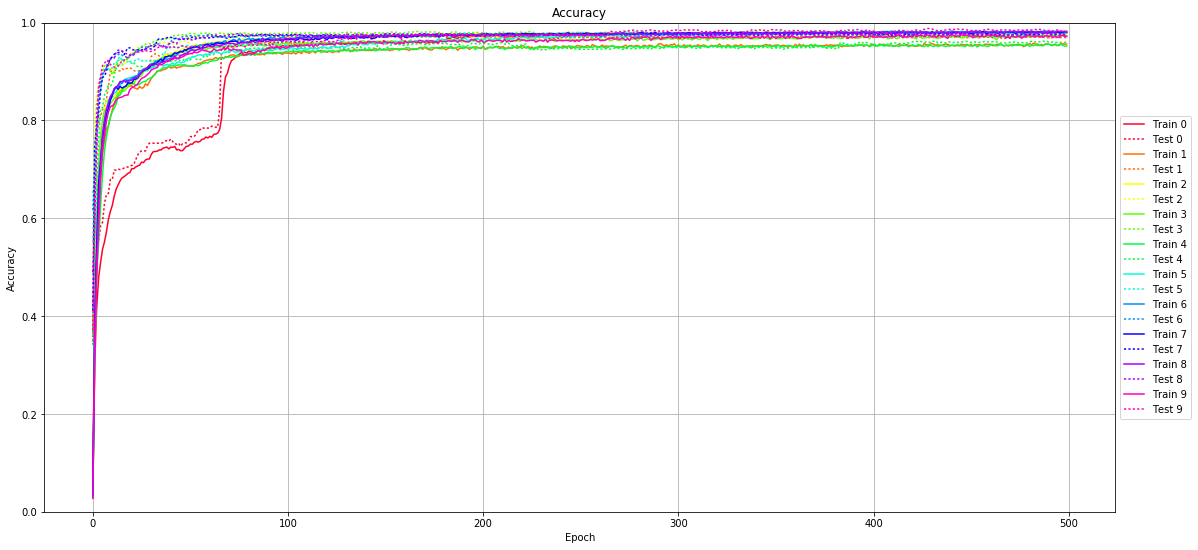

In [28]:
plot_acc(history)

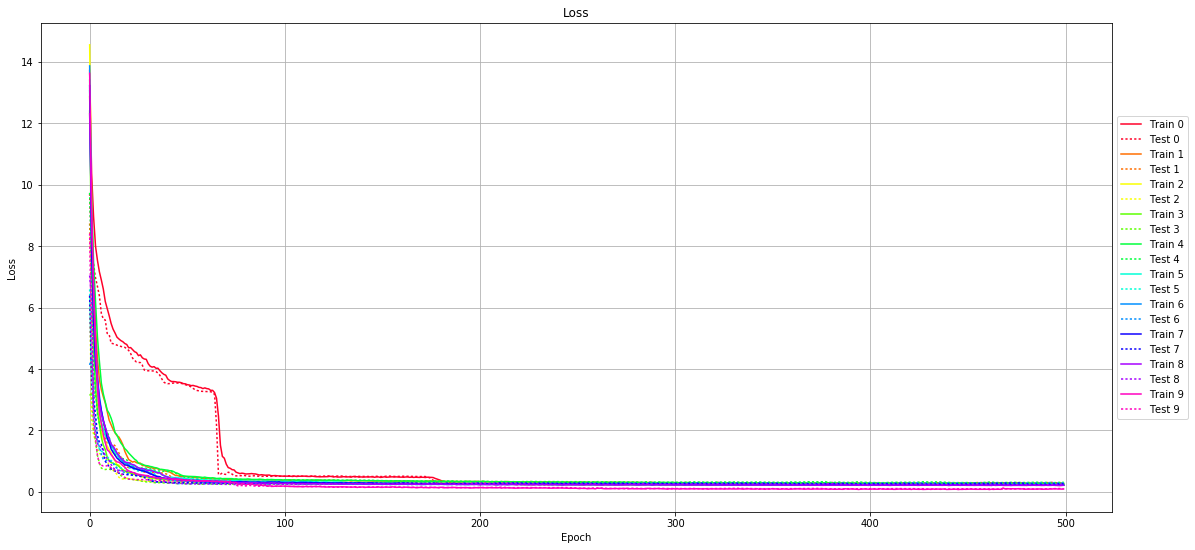

In [29]:
plot_loss(history)

In [30]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


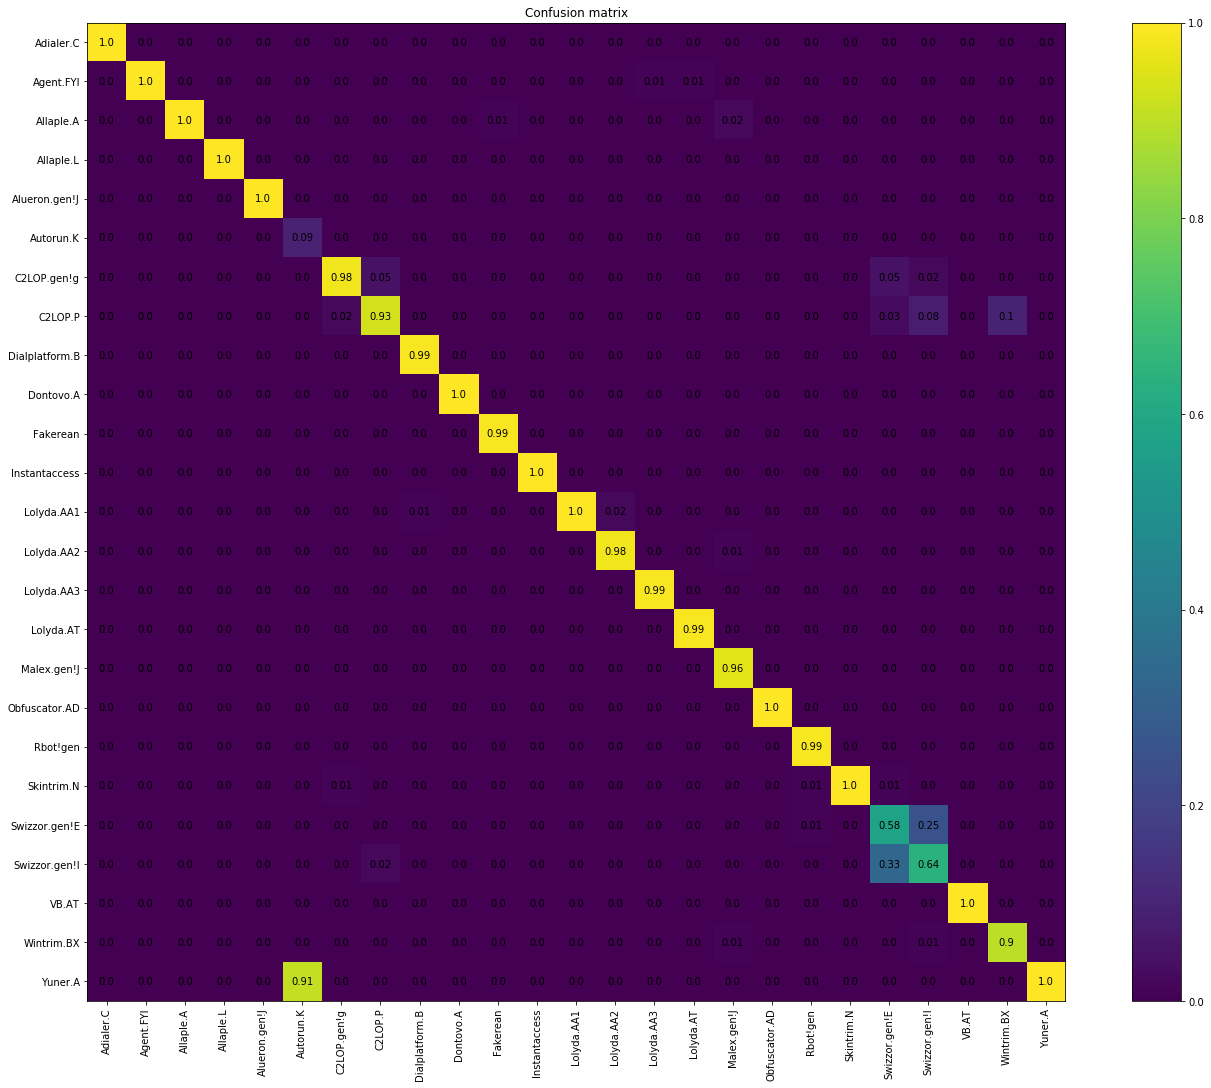

In [31]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()